In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
import statsmodels.formula.api as smf
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
import geopandas as gpd
import locale

locale.setlocale(locale.LC_ALL, 'es_CL')

plt.style.use("seaborn")
plt.rcParams.update({'font.size': 22})
plt.rcParams['axes.grid'] = False
sns.set(font_scale=1.5)

BASE = "/media/giani/Gianicosas/Magister/Proyecto/"

# Datos

In [2]:
df = pd.read_csv(f"{BASE}work_data/matriz_desercion_1.csv.gz")
df[
    ['cat_periodo', 'codigo_unico', 'mrun', 'gen_alu', 'fec_nac_alu',
       'tipo_inst_1', 'region_sede', 'area_conocimiento',
       'region_colegio', 'tipo_ensenanza_colegio',
       'prom_notas_media', 'dependencia_colegio', 'desertor_1']
].rename(columns={
    "cat_periodo": "periodo",
    "tipo_ensenanza_colegio": "tipo_colegio",
    "prom_notas_media": "notas_colegio",
    'dependencia_colegio': "dep_colegio"
}).dropna().sample(2, random_state=42).head()

/tmp/ipykernel_6115/2818672963.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"{BASE}work_data/matriz_desercion_1.csv.gz")


,periodo,codigo_unico,mrun,gen_alu,fec_nac_alu,tipo_inst_1,region_sede,area_conocimiento,region_colegio,tipo_colegio,notas_colegio,dep_colegio,desertor_1
359978,2016,I126S2C286J1V1,14031521.0,2,199005,Institutos Profesionales,Maule,Educación,7,510.0,5.55,3.0,0.0
663976,2017,I143S12C36J1V1,10928204.0,2,199710,Institutos Profesionales,Los Lagos,Salud,10,510.0,5.15,3.0,0.0


# Edad / Género

Esto lo usé para la ppt 

In [3]:
df_plot = df[
    df["fec_nac_alu"] != 190001
][["gen_alu", "desertor_1", "fec_nac_alu", "cat_periodo"]].rename(columns={
    "gen_alu": "Sexo",
    "desertor_1": "Desertor"
})

df_plot["Desertor"] = df_plot["Desertor"].replace([0, 1], ["No", "Sí"])
df_plot["Sexo"] = df_plot["Sexo"].replace([1, 2], ["Hombre", "Mujer"])
df_plot["fecha_n"] = pd.to_datetime([
    date(int(str(d)[:4]), int(str(d)[-2:]), 15)
    for d in df_plot["fec_nac_alu"]
])

df_plot["Edad"] = [
    date(y, 1, 1).year - fn.year - (
        (date(y, 1, 1).month, date(y, 1, 1).day) < (fn.month, fn.day)
    )
    for fn, y in zip(df_plot["fecha_n"], df_plot["cat_periodo"])
]

df_plot.head()

,Sexo,Desertor,fec_nac_alu,cat_periodo,fecha_n,Edad
0,Hombre,No,197808,2015,1978-08-15,36
1,Hombre,No,199102,2015,1991-02-15,23
2,Hombre,Sí,198404,2015,1984-04-15,30
3,Mujer,Sí,198910,2015,1989-10-15,25
4,Mujer,No,198309,2015,1983-09-15,31


In [4]:
df_plot[df_plot["Edad"] > 80]

,Sexo,Desertor,fec_nac_alu,cat_periodo,fecha_n,Edad
283103,Hombre,Sí,193206,2016,1932-06-15,83
882733,Mujer,Sí,193505,2018,1935-05-15,82
892842,Hombre,Sí,193407,2018,1934-07-15,83
913899,Mujer,No,193201,2018,1932-01-15,85
929118,Hombre,Sí,193411,2018,1934-11-15,83
936331,Mujer,Sí,193304,2018,1933-04-15,84
940805,Hombre,Sí,193303,2018,1933-03-15,84
957794,Hombre,Sí,193411,2018,1934-11-15,83
989429,Mujer,No,193308,2018,1933-08-15,84
993472,Mujer,Sí,193303,2018,1933-03-15,84


<AxesSubplot:xlabel='Edad', ylabel='Desertor'>

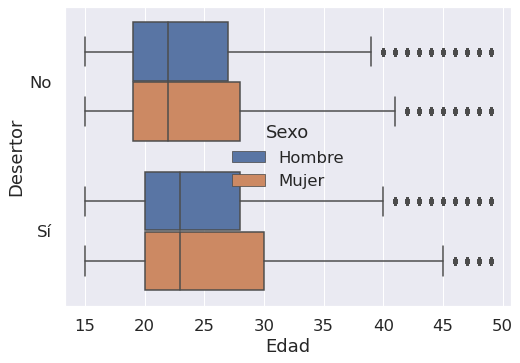

In [5]:
sns.boxplot(data=df_plot[df_plot["Edad"] < 50], x="Edad", y="Desertor", hue="Sexo")

In [6]:
from statsmodels.graphics.mosaicplot import mosaic

Text(0, 0.5, 'Desertor')

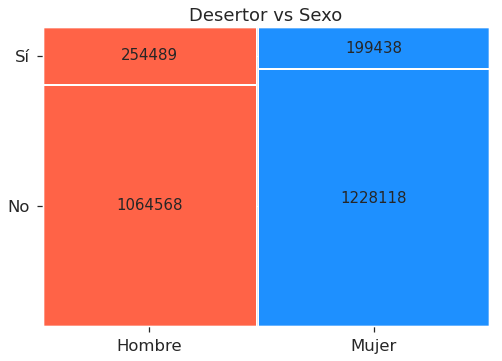

In [7]:
props={}
props[('Hombre','Sí')]={'facecolor':'tomato', 'edgecolor':'white'}
props[('Hombre','No')]={'facecolor':'tomato', 'edgecolor':'white'}
props[('Mujer','Sí')]={'facecolor':'dodgerblue','edgecolor':'white'}
props[('Mujer','No')]=        {'facecolor':'dodgerblue','edgecolor':'white'}
labelizer=lambda k:{('Hombre','Sí'):df_plot[
    (df_plot["Sexo"]=="Hombre") & (df_plot["Desertor"]=="Sí")
].shape[0],('Mujer','Sí'):df_plot[
    (df_plot["Sexo"]=="Mujer") & (df_plot["Desertor"]=="Sí")
].shape[0],('Hombre','No'):df_plot[
    (df_plot["Sexo"]=="Hombre") & (df_plot["Desertor"]=="No")
].shape[0],('Mujer','No'):df_plot[
    (df_plot["Sexo"]=="Mujer") & (df_plot["Desertor"]=="No")
].shape[0]}[k]
mosaic(df_plot,['Sexo','Desertor'],labelizer=labelizer,properties=props, title="Desertor vs Sexo")
plt.ylabel("Desertor")

# Deserción

In [8]:
df["anio_desercion"] = df["cat_periodo"] + 1

In [9]:
porc_des = pd.DataFrame(df.groupby(["anio_desercion"])["desertor_1"].value_counts("%").rename("%") * 100).reset_index()
porc_des = porc_des[porc_des["desertor_1"]==1]
porc_des

,anio_desercion,desertor_1,%
1,2016,1.0,16.382254
3,2017,1.0,14.418847
5,2018,1.0,13.360973
7,2019,1.0,13.062208
9,2020,1.0,15.068913
11,2021,1.0,16.939409
13,2022,1.0,24.696973


# Region de institución

In [10]:
df["region_sede"].unique()

array(['Biobío', 'Metropolitana', 'Coquimbo', 'Antofagasta', 'Valparaíso',
       'Los Lagos', "Lib. Gral B. O'Higgins", 'Arica y Parinacota',
       'La Araucanía', 'Atacama', 'Los Ríos', 'Maule', 'Ñuble',
       'Magallanes', 'Tarapacá', 'Aysén'], dtype=object)

In [11]:
order_reg = [
    'Arica y Parinacota','Tarapacá','Antofagasta','Atacama',
    'Coquimbo','Valparaíso','Metropolitana',"Lib. Gral B. O'Higgins",
    'Maule', 'Ñuble', 'Biobío','La Araucanía', 'Los Ríos',
    'Los Lagos', 'Aysén', 'Magallanes'
]

assert len(order_reg) == df["region_sede"].nunique()

## Matriculados por región por año

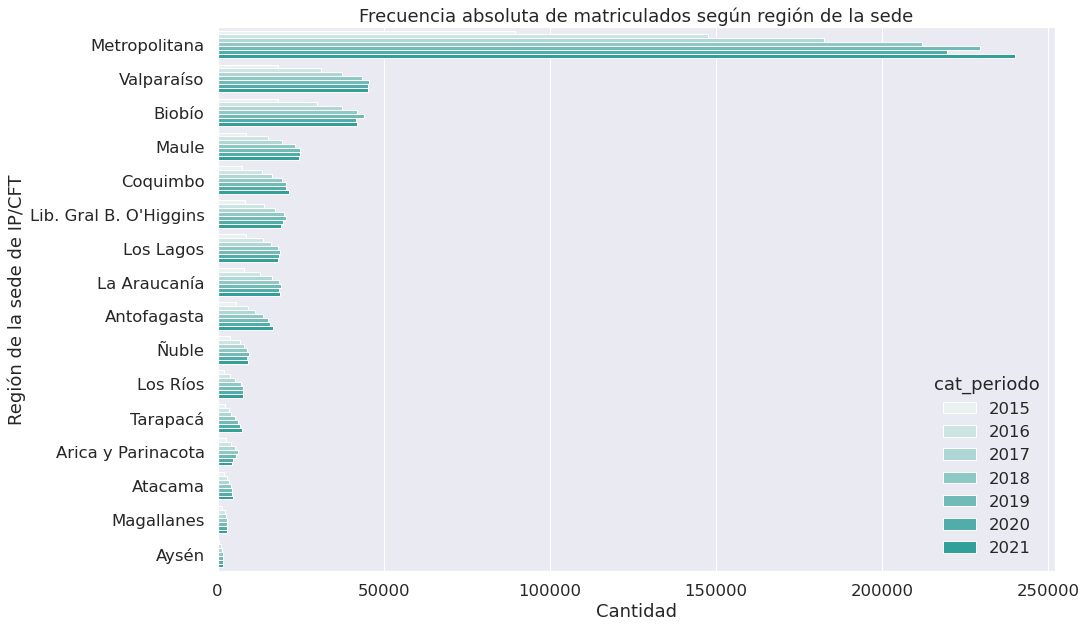

In [12]:
plt.figure(figsize=(15, 10))
sns.countplot(
    data=df,
    y="region_sede",
    order=df["region_sede"].value_counts().index,
    color="lightseagreen",
    hue="cat_periodo"
)
plt.ylabel("Región de la sede de IP/CFT")
plt.xlabel("Cantidad")
plt.title("Frecuencia absoluta de matriculados según región de la sede");

## % Desertores por región por año

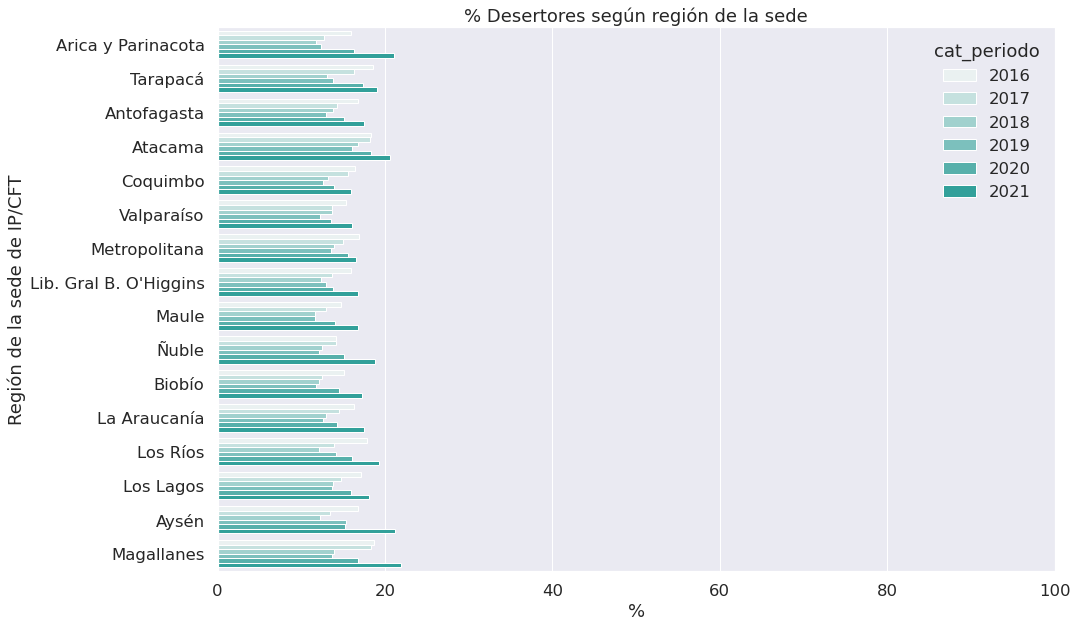

In [13]:
tmp_time = df.groupby([
    "cat_periodo", "region_sede"
])["desertor_1"].value_counts("%").mul(100).rename('%').reset_index()

plot_time = tmp_time[
    (tmp_time["desertor_1"]==1)
    & (tmp_time["cat_periodo"]<2021)
].copy()
plot_time["cat_periodo"] = plot_time["cat_periodo"] + 1

plt.figure(figsize=(15, 10))
sns.barplot(
    data=plot_time,
    y="region_sede",
    x="%",
    order=order_reg,
    color="lightseagreen",
    hue="cat_periodo"
)
plt.ylabel("Región de la sede de IP/CFT")
plt.xlabel("%")
plt.xlim([0, 100])
plt.title("% Desertores según región de la sede");

## % Desertores totales (ruts únicos en la ventana de tiempo) por región

In [14]:
df_region_sede = df[[
    "mrun", "desertor_1", "region_sede"
]].drop_duplicates().sort_values(
    by=["desertor_1"], ascending=False
).drop_duplicates(subset=["mrun"])
df_region_sede.shape, df_region_sede["mrun"].nunique()

((1157169, 3), 1157169)

In [15]:
df_region_sede["desertor_1"].value_counts("%")

0.0    0.60895
1.0    0.39105
Name: desertor_1, dtype: float64

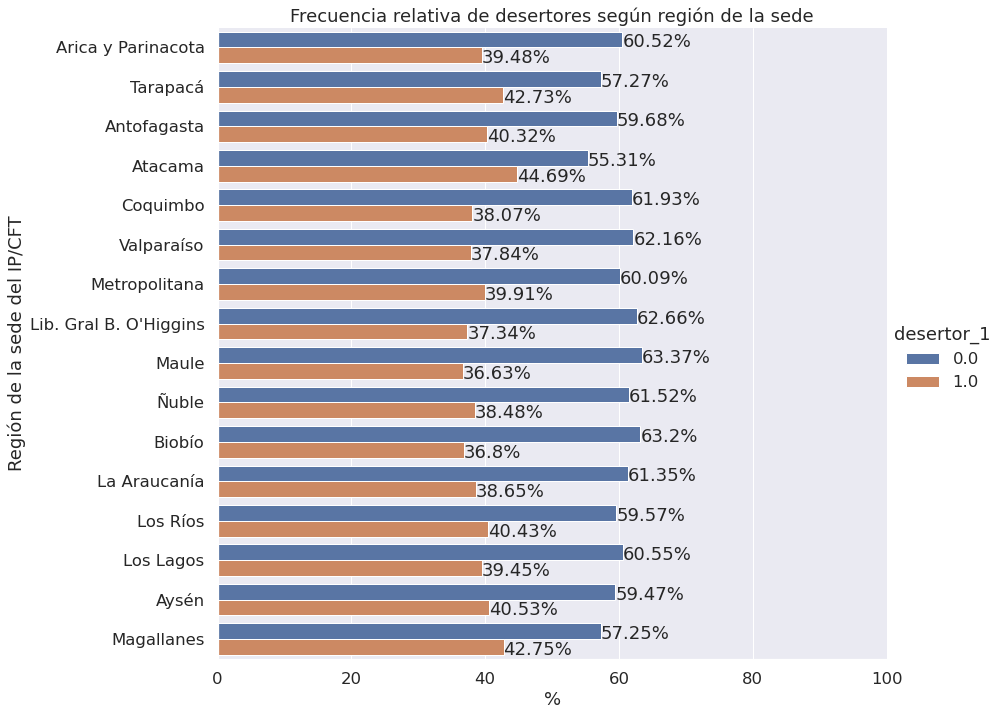

In [16]:
df1 = df_region_sede.groupby([
    "region_sede"
])["desertor_1"].value_counts("%").mul(100).rename('%').reset_index()

g = sns.catplot(
    y="region_sede",
    x='%',
    hue="desertor_1",
    kind='bar',
    data=df1,
    height=10,
    aspect=1.3,
    order=order_reg
)
g.ax.set_xlim(0,100)
g.ax.set_ylabel("Región de la sede del IP/CFT")

for p in g.ax.patches:
    g.ax.text(
        p.get_width(),
        p.get_y()+0.4,
        str(p.get_width().round(2)) + '%'
    )
    
plt.title("Frecuencia relativa de desertores según región de la sede");

## % Desertores totales en cada región respecto del total nacional

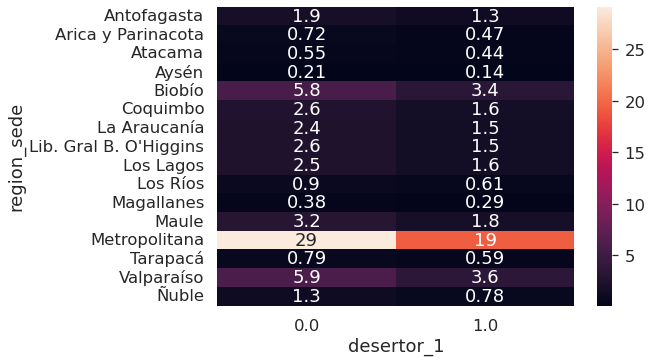

In [17]:
sns.heatmap(pd.crosstab(columns=df_region_sede["desertor_1"], index=df_region_sede["region_sede"], normalize="all") * 100, annot=True);

In [18]:
(pd.crosstab(columns=df_region_sede["desertor_1"], index=df_region_sede["region_sede"])).sum().sum(), df_region_sede.shape

(1157169, (1157169, 3))

In [19]:
# https://thinkingneuron.com/how-to-measure-the-correlation-between-two-categorical-variables-in-python/
# https://medium.com/@ritesh.110587/correlation-between-categorical-variables-63f6bd9bf2f7
chi2_contingency(pd.crosstab(columns=df_region_sede["desertor_1"], index=df_region_sede["region_sede"]))

(1030.69475601845,
 3.5440250693340023e-210,
 15,
 array([[ 22411.79381058,  14392.20618942],
        [  8401.07345427,   5394.92654573],
        [  7009.01387783,   4500.98612217],
        [  2483.29787957,   1594.70212043],
        [ 64676.57375889,  41533.42624111],
        [ 30068.73043091,  19309.26956909],
        [ 28007.43486388,  17985.56513612],
        [ 29109.02531609,  18692.97468391],
        [ 28694.33040291,  18426.66959709],
        [ 10652.97035437,   6841.02964563],
        [  4730.93213005,   3038.06786995],
        [ 35583.38114139,  22850.61885861],
        [342011.86554082, 219630.13445918],
        [  9676.82359102,   6214.17640898],
        [ 66769.5347231 ,  42877.4652769 ],
        [ 14371.21872432,   9228.78127568]]))

## Mapas Geo

In [20]:
# Scar del link del readme
regiones = gpd.read_file('regiones.geojson').to_crs(epsg=4326)
regiones.head()

,objectid,cir_sena,codregion,area_km,st_area_sh,st_length_,Region,geometry
0,1084,1,15,16866.819844,1.886869e+10,7.505296e+05,Región de Arica y Parinacota,"POLYGON ((-69.41531 -17.65521, -69.40802 -17.6..."
1,1085,2,1,42284.567484,4.830637e+10,1.213713e+06,Región de Tarapacá,"MULTIPOLYGON (((-70.16034 -20.21070, -70.16031..."
2,1086,3,2,126071.431981,1.508452e+11,2.516112e+06,Región de Antofagasta,"MULTIPOLYGON (((-70.70164 -25.89174, -70.70130..."
3,1087,15,12,133053.142345,3.581316e+11,9.049830e+07,Región de Magallanes y Antártica Chilena,"MULTIPOLYGON (((-67.32026 -55.92015, -67.31971..."
4,1088,14,11,106703.377369,2.242743e+11,4.144481e+07,Región de Aysén del Gral.Ibañez del Campo,"MULTIPOLYGON (((-75.57992 -48.75893, -75.58028..."


In [21]:
regiones.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [23]:
regiones["Region"] = regiones["Region"].replace(
    sorted(regiones["Region"].unique())[:-1],
    [
        "Metropolitana", "Antofagasta", "Arica y Parinacota", "Atacama", "Aysén", "Coquimbo", "La Araucanía", "Los Lagos", "Los Ríos",
        "Magallanes", "Tarapacá", "Valparaíso", "Ñuble", "Biobío", "Lib. Gral B. O'Higgins", "Maule"
    ]
)

In [24]:
cantidades = df[df["anio_desercion"] < 2022][
    ["anio_desercion", "mrun", "desertor_1", "region_sede"]
].drop_duplicates().rename(columns={
    "region_sede": "Region"
}).groupby(["anio_desercion", "Region"]).agg({
    "mrun": pd.Series.nunique,
    "desertor_1": "sum"
}).reset_index()#.groupby(["Region"]).agg({"mrun": "mean","desertor_1": "mean"}).reset_index().round()

cantidades.head()

,anio_desercion,Region,mrun,desertor_1
0,2016,Antofagasta,5505,927.0
1,2016,Arica y Parinacota,2431,389.0
2,2016,Atacama,1884,345.0
3,2016,Aysén,570,96.0
4,2016,Biobío,18087,2726.0


In [25]:
cantidades["desertor_1_porc"] = [
    (d / cantidades[
        (cantidades["anio_desercion"] == a)
        & (cantidades["Region"] == r)
    ]["mrun"].sum()) * 100 
    for a, d, r in zip(cantidades["anio_desercion"], cantidades["desertor_1"], cantidades["Region"])
]

cantidades.head()

,anio_desercion,Region,mrun,desertor_1,desertor_1_porc
0,2016,Antofagasta,5505,927.0,16.839237
1,2016,Arica y Parinacota,2431,389.0,16.001645
2,2016,Atacama,1884,345.0,18.312102
3,2016,Aysén,570,96.0,16.842105
4,2016,Biobío,18087,2726.0,15.071598


In [26]:
regiones_mat_des = gpd.GeoDataFrame(pd.merge(
    cantidades,
    regiones[["Region", "geometry"]],
    how="left"
))

In [27]:
regiones_mat_des["centro"] = regiones_mat_des["geometry"].centroid.to_crs(4326)
centros = regiones_mat_des[["centro", "Region"]].drop_duplicates().set_geometry("centro")
centros

/tmp/ipykernel_6115/634898938.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  regiones_mat_des["centro"] = regiones_mat_des["geometry"].centroid.to_crs(4326)


,centro,Region
0,POINT (-69.11932 -23.53608),Antofagasta
1,POINT (-69.62844 -18.49679),Arica y Parinacota
2,POINT (-69.90998 -27.39531),Atacama
3,POINT (-73.25427 -46.41637),Aysén
4,POINT (-72.39397 -37.49952),Biobío
5,POINT (-70.86065 -30.61921),Coquimbo
6,POINT (-72.27464 -38.64950),La Araucanía
7,POINT (-71.04654 -34.43534),Lib. Gral B. O'Higgins
8,POINT (-72.89504 -42.04196),Los Lagos
9,POINT (-72.57011 -40.00528),Los Ríos


In [28]:
# # create the colorbar
norm = colors.Normalize(vmin=cantidades["desertor_1_porc"].min(), vmax=cantidades["desertor_1_porc"].max())
colores = cm.get_cmap('coolwarm', 256)
cbar = plt.cm.ScalarMappable(norm=norm, cmap=colores)

/tmp/ipykernel_6115/903760390.py:54: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax_cbar = fig.colorbar(cbar, ax=axes, location="bottom", orientation="horizontal")


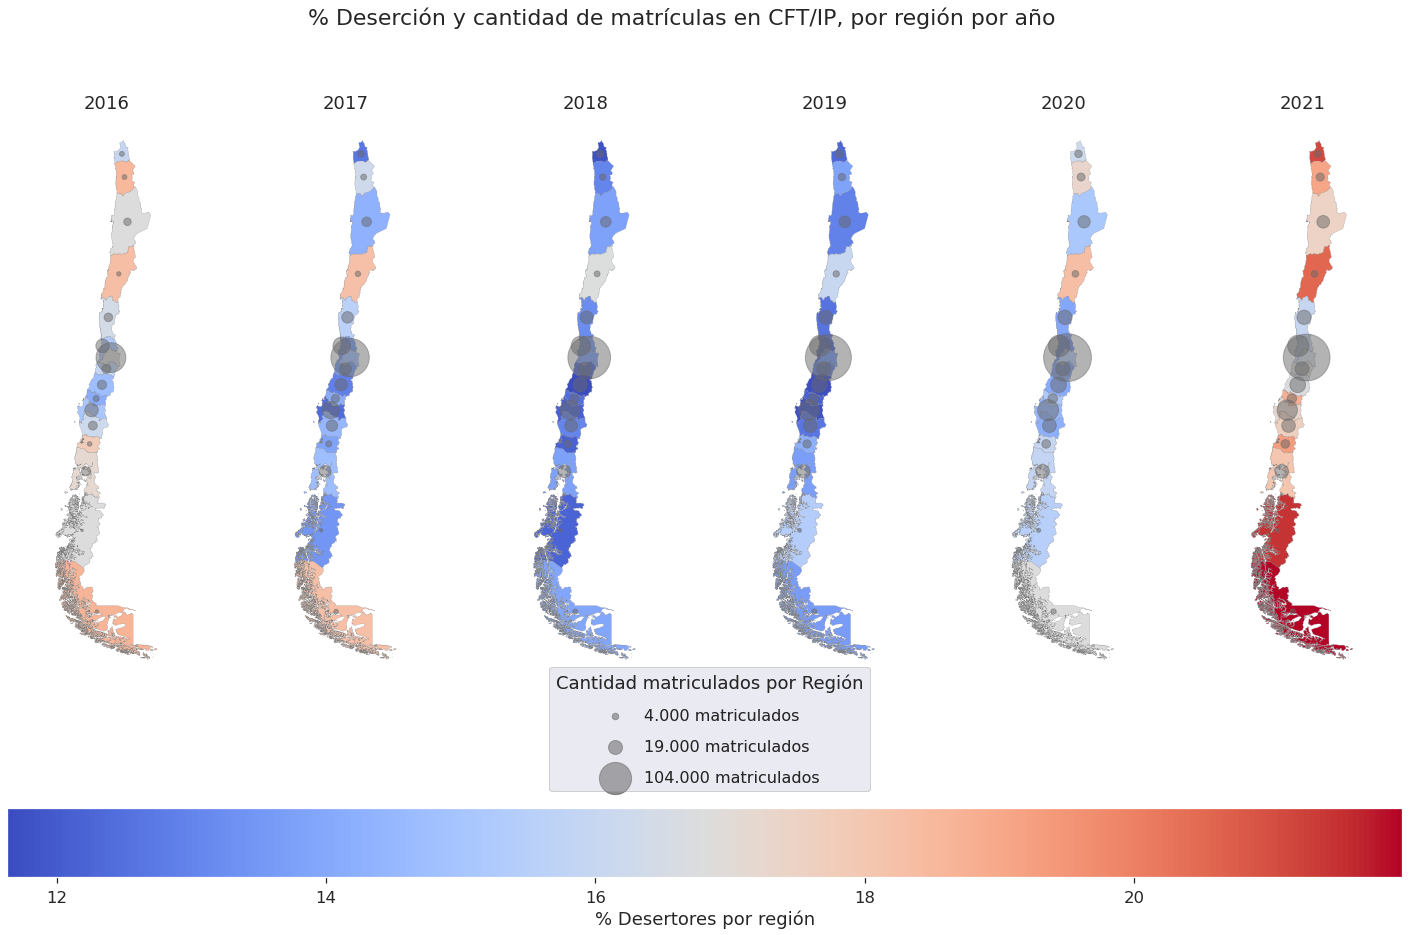

In [33]:
# plot
anios = sorted(regiones_mat_des["anio_desercion"].unique())
fig, axes = plt.subplots(figsize=(25,15), ncols=len(anios), nrows=1);
axes = axes.flatten()
plt.suptitle("% Deserción y cantidad de matrículas en CFT/IP, por región por año", fontsize=22)

for i, a in enumerate(anios):
    t = regiones_mat_des[
        (regiones_mat_des["anio_desercion"]==a)
    ].copy()

    base = t.plot(
        ax=axes[i],
        column="desertor_1_porc",
        #legend=True,
        linewidth=0.2,
        cmap=colores,
        norm=norm,
        edgecolor="grey"
    );
    centros.plot(
        ax=base,
        marker="o",
        color="dimgrey",
        markersize=t["mrun"] / 100,
        alpha=0.5,
        legend=True
    );
    axes[i].set_xlim([-77, -65]);
    axes[i].set_title(a);
    axes[i].set_axis_off();
    axes[i].grid(None);
    
    if i == len(axes) - 1:
        # Adds three phantom data points to the map, plotted off-screen at lat=lon=0
        for area in (cantidades["mrun"]).quantile([.25, .75, .95]):
            axes[i].scatter(
                [0], [0], c='dimgrey',
                alpha=0.5, s=area / 100, label=f'{locale.format_string("%.f", int(np.round(area, -3)), grouping=True)} matriculados'
            )

        # Creates the legend with black circles
        legend1 = axes[i].legend(
            scatterpoints=1, frameon=True, labelspacing=1, loc='lower center', fontsize=16, 
            bbox_to_anchor=(-4, -0.2),
            title="Cantidad matriculados por Región",
            title_fontsize=18
        )

        # Adds the legend above to the current axes in the figure
        fig.gca().add_artist(legend1)

# add colorbar
ax_cbar = fig.colorbar(cbar, ax=axes, location="bottom", orientation="horizontal")
ax_cbar.set_label('% Desertores por región')
#ax_cbar.set_yticklabels(['{0:.2f}%'.format(ytick*100) for ytick in yticks])

## Modelos descriptivos
### Regresión considerando ruts únicos en el periodo

In [20]:
df_regiones = pd.get_dummies(
    df_region_sede[["region_sede"]],
    prefix="",
    prefix_sep=""
).drop(columns=["Metropolitana"]).rename(columns={
    "Lib. Gral B. O'Higgins": "Lib. Gral B. OHiggins"
})
df_log1 = pd.concat([
    df_region_sede[["desertor_1"]],
    df_regiones
], axis=1)

df_log1.columns = [c.replace(" ", "_").replace(".", "") for c in df_log1.columns]
" + ".join(df_log1.columns[1:])

'Antofagasta + Arica_y_Parinacota + Atacama + Aysén + Biobío + Coquimbo + La_Araucanía + Lib_Gral_B_OHiggins + Los_Lagos + Los_Ríos + Magallanes + Maule + Tarapacá + Valparaíso + Ñuble'

In [21]:
logit_1 = smf.logit(f"desertor_1 ~ {' + '.join(df_log1.columns[1:])}", data=df_log1).fit()

Optimization terminated successfully.
         Current function value: 0.668770
         Iterations 4


In [22]:
logit_1.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
=====================================================================
Model:                Logit            Pseudo R-squared: 0.001       
Dependent Variable:   desertor_1       AIC:              1547792.4153
Date:                 2022-09-28 10:59 BIC:              1547983.7991
No. Observations:     1157169          Log-Likelihood:   -7.7388e+05 
Df Model:             15               LL-Null:          -7.7440e+05 
Df Residuals:         1157153          LLR p-value:      4.1349e-210 
Converged:            1.0000           Scale:            1.0000      
No. Iterations:       4.0000                                         
---------------------------------------------------------------------
                     Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
Intercept           -0.4091   0.0027 -150.1435 0.0000 -0.4144 -0.4038
Antofagasta          0.0168   0.0110    1.5310 0.1258 -0.0047  0.0383
Arica_y_Parinacota  -0.0180   0.0176   -1.0197 0.3079 -0.0525  0.0166
Atacama              0.1960   0.0189   10.3437 0.0000  0.1588  0.2331
Aysén                0.0259   0.0320    0.8078 0.4192 -0.0369  0.0886
Biobío              -0.1317   0.0069  -19.0303 0.0000 -0.1453 -0.1182
Coquimbo            -0.0777   0.0097   -8.0397 0.0000 -0.0966 -0.0587
La_Araucanía        -0.0532   0.0100   -5.3393 0.0000 -0.0727 -0.0336
Lib_Gral_B_OHiggins -0.1084   0.0098  -11.0162 0.0000 -0.1277 -0.0891
Los_Lagos           -0.0193   0.0098   -1.9637 0.0496 -0.0385 -0.0000
Los_Ríos             0.0216   0.0156    1.3782 0.1681 -0.0091  0.0522
Magallanes           0.1169   0.0231    5.0623 0.0000  0.0716  0.1622
Maule               -0.1388   0.0090  -15.4117 0.0000 -0.1565 -0.1212
Tarapacá             0.1162   0.0163    7.1418 0.0000  0.0843  0.1480
Valparaíso          -0.0871   0.0068  -12.8157 0.0000 -0.1004 -0.0738
Ñuble               -0.0602   0.0137   -4.4072 0.0000 -0.0869 -0.0334
=====================================================================

"""

In [23]:
logit_1.llf,  logit_1.llnull

(-773880.2076588265, -774395.3988620762)

In [24]:
coefs = logit_1.summary2().tables[1]
coefs[(coefs["P>|z|"]<0.05) & (coefs["Coef."] > 0)]

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Atacama,0.195960,0.018945,10.343660,4.471283e-25,0.158828,0.233091
Magallanes,0.116912,0.023095,5.062298,4.142332e-07,0.071647,0.162176
Tarapacá,0.116167,0.016266,7.141762,9.214193e-13,0.084286,0.148047


In [25]:
coefs[coefs["P>|z|"]>0.05]

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Antofagasta,0.016796,0.010970,1.531048,0.125758,-0.004705,0.038297
Arica_y_Parinacota,-0.017977,0.017629,-1.019713,0.307865,-0.052529,0.016576
Aysén,0.025860,0.032012,0.807840,0.419183,-0.036882,0.088602
Los_Ríos,0.021562,0.015645,1.378191,0.168144,-0.009102,0.052226


In [26]:
atacama = smf.logit(f"desertor_1 ~ Atacama", data=df_log1).fit()
atacama.summary2()

Optimization terminated successfully.
         Current function value: 0.669151
         Iterations 4


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
===================================================================
Model:              Logit            Pseudo R-squared: 0.000       
Dependent Variable: desertor_1       AIC:              1548644.6245
Date:               2022-09-28 10:59 BIC:              1548668.5475
No. Observations:   1157169          Log-Likelihood:   -7.7432e+05 
Df Model:           1                LL-Null:          -7.7440e+05 
Df Residuals:       1157167          LLR p-value:      1.5889e-34  
Converged:          1.0000           Scale:            1.0000      
No. Iterations:     4.0000                                         
--------------------------------------------------------------------
               Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
--------------------------------------------------------------------
Intercept     -0.4453    0.0019  -232.5062  0.0000  -0.4490  -0.4415
Atacama        0.2321    0.0188    12.3169  0.0000   0.1952   0.2691
===================================================================

"""

### Regresión región binarizada rm / otra

In [27]:
df_region_sede["es_metropolitana"] = np.where(df_region_sede["region_sede"]=="Metropolitana", 1, 0)

logit_2 = smf.logit(f"desertor_1 ~ es_metropolitana", data=df_region_sede).fit()
logit_2.summary2()

Optimization terminated successfully.
         Current function value: 0.669086
         Iterations 4


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
===================================================================
Model:              Logit            Pseudo R-squared: 0.000       
Dependent Variable: desertor_1       AIC:              1548495.7810
Date:               2022-09-28 10:59 BIC:              1548519.7040
No. Observations:   1157169          Log-Likelihood:   -7.7425e+05 
Df Model:           1                LL-Null:          -7.7440e+05 
Df Residuals:       1157167          LLR p-value:      5.3950e-67  
Converged:          1.0000           Scale:            1.0000      
No. Iterations:     4.0000                                         
-------------------------------------------------------------------
                   Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------
Intercept         -0.4750   0.0027 -178.2319 0.0000 -0.4802 -0.4698
es_metropolitana   0.0659   0.0038   17.2920 0.0000  0.0584  0.0734
===================================================================

"""

In [28]:
logit_2.llf, logit_2.llnull, logit_1.llf, atacama.llf

(-774245.8904943807,
 -774395.3988620762,
 -773880.2076588265,
 -774320.3122555191)

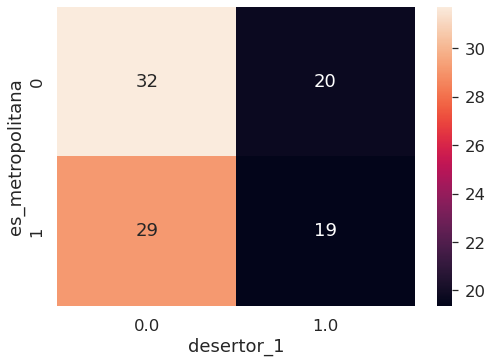

In [29]:
sns.heatmap(pd.crosstab(columns=df_region_sede["desertor_1"], index=df_region_sede["es_metropolitana"], normalize="all") * 100, annot=True);

In [30]:
chi2_contingency(pd.crosstab(columns=df_region_sede["desertor_1"], index=df_region_sede["es_metropolitana"]))[1] < 0.05

True

In [31]:
t1 = pd.get_dummies(
    df[df["anio_desercion"]==2021][["region_sede"]],
    prefix="",
    prefix_sep=""
).drop(columns=["Metropolitana"]).rename(columns={
    "Lib. Gral B. O'Higgins": "Lib. Gral B. OHiggins"
})
t_l1 = pd.concat([
    df[df["anio_desercion"]==2021][["desertor_1"]],
    t1
], axis=1)

t_l1.columns = [c.replace(" ", "_").replace(".", "") for c in df_log1.columns]
" + ".join(t_l1.columns[1:])

mt1 = smf.logit(f"desertor_1 ~ {' + '.join(t_l1.columns[1:])}", data=t_l1).fit()
mt1.summary2()

Optimization terminated successfully.
         Current function value: 0.454573
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
=====================================================================
Model:               Logit             Pseudo R-squared:  0.001      
Dependent Variable:  desertor_1        AIC:               418812.3778
Date:                2022-09-28 10:59  BIC:               418989.0234
No. Observations:    460630            Log-Likelihood:    -2.0939e+05
Df Model:            15                LL-Null:           -2.0955e+05
Df Residuals:        460614            LLR p-value:       8.8727e-60 
Converged:           1.0000            Scale:             1.0000     
No. Iterations:      5.0000                                          
---------------------------------------------------------------------
                     Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
Intercept           -1.6190   0.0057 -281.7569 0.0000 -1.6302 -1.6077
Antofagasta          0.0646   0.0217    2.9822 0.0029  0.0221  0.1071
Arica_y_Parinacota   0.3008   0.0366    8.2230 0.0000  0.2291  0.3726
Atacama              0.2671   0.0381    7.0027 0.0000  0.1924  0.3419
Aysén                0.3089   0.0602    5.1348 0.0000  0.1910  0.4269
Biobío               0.0512   0.0142    3.6032 0.0003  0.0233  0.0790
Coquimbo            -0.0427   0.0199   -2.1397 0.0324 -0.0818 -0.0036
La_Araucanía         0.0714   0.0202    3.5351 0.0004  0.0318  0.1109
Lib_Gral_B_OHiggins  0.0206   0.0200    1.0310 0.3025 -0.0185  0.0597
Los_Lagos            0.1066   0.0199    5.3559 0.0000  0.0676  0.1456
Los_Ríos             0.1855   0.0298    6.2315 0.0000  0.1272  0.2439
Magallanes           0.3505   0.0457    7.6674 0.0000  0.2609  0.4401
Maule                0.0150   0.0180    0.8340 0.4043 -0.0202  0.0502
Tarapacá             0.1732   0.0318    5.4423 0.0000  0.1108  0.2356
Valparaíso          -0.0368   0.0140   -2.6218 0.0087 -0.0643 -0.0093
Ñuble                0.1533   0.0276    5.5495 0.0000  0.0992  0.2074
=====================================================================

"""

## Predicción usando todas las regiones

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    df_log1.drop(columns=["desertor_1"]),
    df_log1["desertor_1"],
    test_size=0.33,
    random_state=42
)

rl_1 = LogisticRegression().fit(X_train, y_train)
y_hat = rl_1.predict(X_test)

print(classification_report(y_test, y_hat))

/home/giani/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/giani/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.61      1.00      0.76    232417
         1.0       0.00      0.00      0.00    149449

    accuracy                           0.61    381866
   macro avg       0.30      0.50      0.38    381866
weighted avg       0.37      0.61      0.46    381866



/home/giani/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


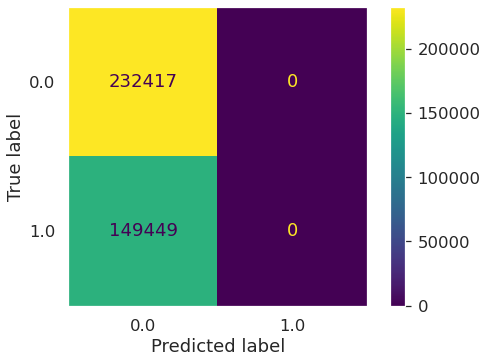

In [33]:
cm = confusion_matrix(y_test, y_hat, labels=rl_1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rl_1.classes_)
disp.plot()
plt.grid(False);

In [34]:
dec_tree = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)
print(classification_report(y_test, dec_tree.predict(X_test)))

/home/giani/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.61      1.00      0.76    232417
         1.0       0.00      0.00      0.00    149449

    accuracy                           0.61    381866
   macro avg       0.30      0.50      0.38    381866
weighted avg       0.37      0.61      0.46    381866



/home/giani/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/giani/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
from sklearn.tree import export_text
print(export_text(dec_tree, feature_names=['Antofagasta', 'Arica_y_Parinacota', 'Atacama', 'Aysén', 'Biobío',
       'Coquimbo', 'La_Araucanía', 'Lib_Gral_B_OHiggins', 'Los_Lagos',
       'Los_Ríos', 'Magallanes', 'Maule', 'Tarapacá', 'Valparaíso', 'Ñuble']))

|--- Biobío <= 0.50
|   |--- Maule <= 0.50
|   |   |--- Atacama <= 0.50
|   |   |   |--- Valparaíso <= 0.50
|   |   |   |   |--- Lib_Gral_B_OHiggins <= 0.50
|   |   |   |   |   |--- Tarapacá <= 0.50
|   |   |   |   |   |   |--- Coquimbo <= 0.50
|   |   |   |   |   |   |   |--- La_Araucanía <= 0.50
|   |   |   |   |   |   |   |   |--- Magallanes <= 0.50
|   |   |   |   |   |   |   |   |   |--- Ñuble <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- Los_Lagos <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |   |   |   |   |   |   |--- Los_Lagos >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |   |   |--- Ñuble >  0.50
|   |   |   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |   |--- Magallanes >  0.50
|   |   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |--- La_Araucanía >  0.50
|   |   |   |   |   |   |   |   |--- class: 0.0
|   | 

# Área del conocimiento de la carrera

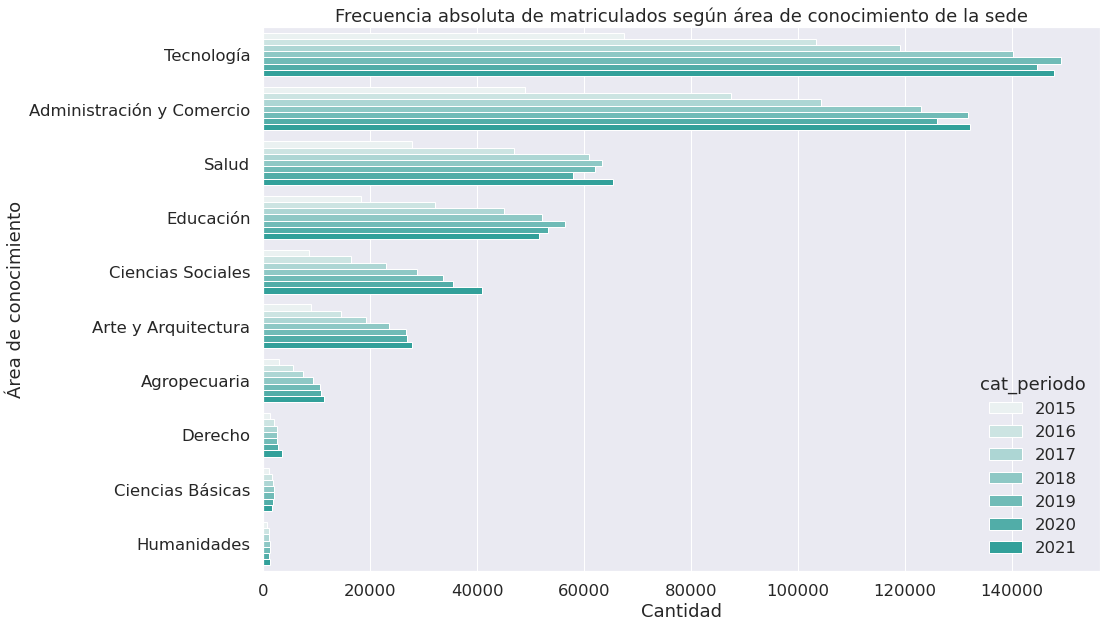

In [36]:
plt.figure(figsize=(15, 10))
sns.countplot(
    data=df,
    y="area_conocimiento",
    order=df["area_conocimiento"].value_counts().index,
    color="lightseagreen",
    hue="cat_periodo"
)
plt.ylabel("Área de conocimiento")
plt.xlabel("Cantidad")
plt.title("Frecuencia absoluta de matriculados según área de conocimiento de la sede");

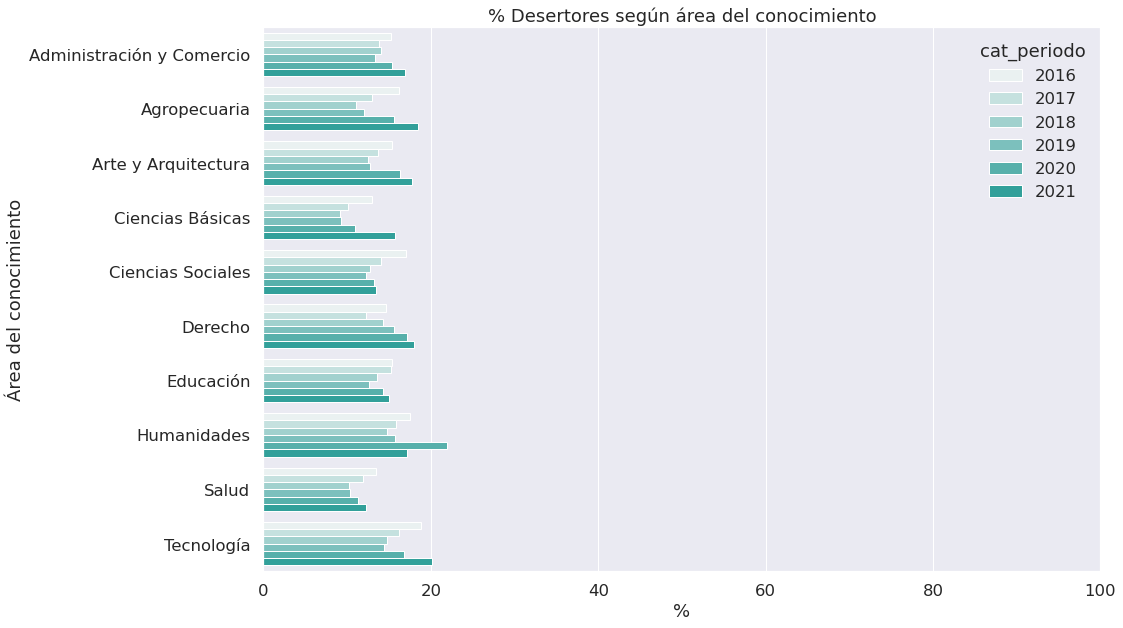

In [37]:
tmp_time_ac = df.groupby([
    "cat_periodo", "area_conocimiento"
])["desertor_1"].value_counts("%").mul(100).rename('%').reset_index()

plot_time_ac = tmp_time_ac[
    (tmp_time_ac["desertor_1"]==1)
    & (tmp_time_ac["cat_periodo"]<2021)
].copy()
plot_time_ac["cat_periodo"] = plot_time_ac["cat_periodo"] + 1

plt.figure(figsize=(15, 10))
sns.barplot(
    data=plot_time_ac,
    y="area_conocimiento",
    x="%",
    color="lightseagreen",
    hue="cat_periodo"
)
plt.ylabel("Área del conocimiento")
plt.xlabel("%")
plt.xlim([0, 100])
plt.title("% Desertores según área del conocimiento");

In [38]:
df_area_conocimiento = df[[
    "mrun", "desertor_1", "area_conocimiento"
]].drop_duplicates().sort_values(
    by=["desertor_1"], ascending=False
).drop_duplicates(subset=["mrun"])
df_area_conocimiento.shape, df_area_conocimiento["mrun"].nunique()

((1157169, 3), 1157169)

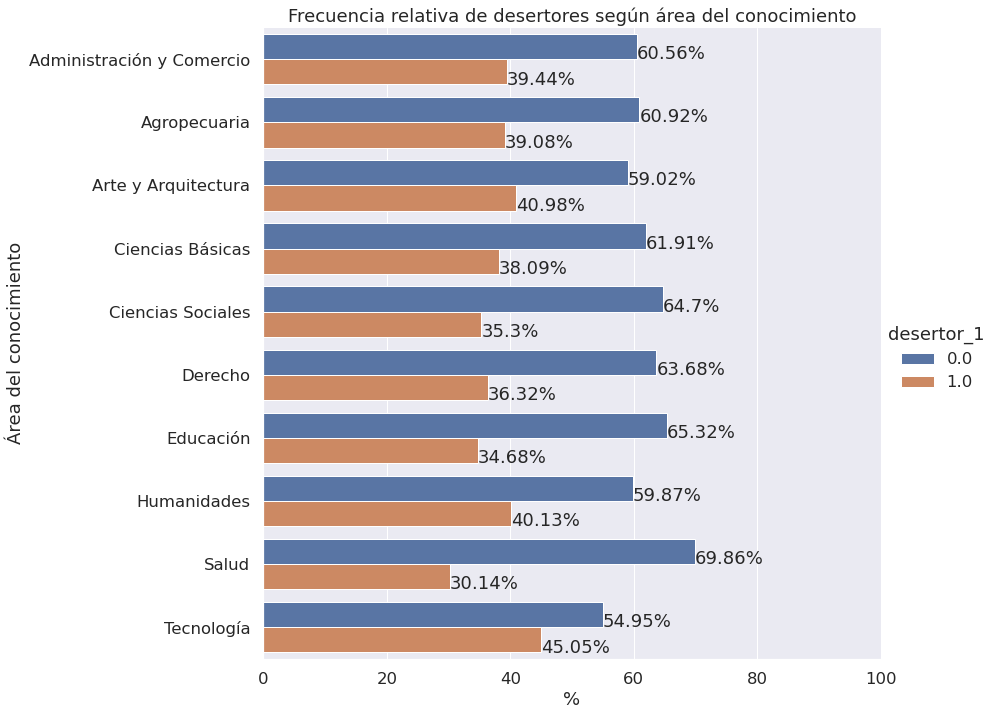

In [39]:
df2 = df_area_conocimiento.groupby([
    "area_conocimiento"
])["desertor_1"].value_counts("%").mul(100).rename('%').reset_index()

g = sns.catplot(
    y="area_conocimiento",
    x='%',
    hue="desertor_1",
    kind='bar',
    data=df2,
    height=10,
    aspect=1.3
)
g.ax.set_xlim(0,100)
g.ax.set_ylabel("Área del conocimiento")

for p in g.ax.patches:
    g.ax.text(
        p.get_width(),
        p.get_y()+0.4,
        str(p.get_width().round(2)) + '%'
    )
    
plt.title("Frecuencia relativa de desertores según área del conocimiento");

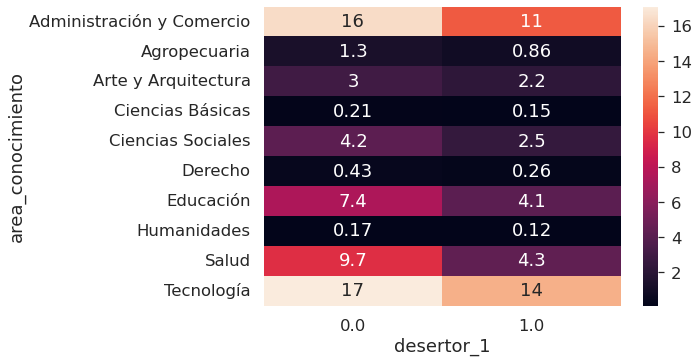

In [40]:
sns.heatmap(pd.crosstab(columns=df_region_sede["desertor_1"], index=df_area_conocimiento["area_conocimiento"], normalize="all") * 100, annot=True);

In [41]:
df_area_conocimiento["area_conocimiento"].value_counts()

Tecnología                   361651
Administración y Comercio    319643
Salud                        161662
Educación                    134338
Ciencias Sociales             79269
Arte y Arquitectura           60039
Agropecuaria                  24691
Derecho                        8177
Ciencias Básicas               4290
Humanidades                    3409
Name: area_conocimiento, dtype: int64

In [42]:
t1 = pd.get_dummies(
    df_area_conocimiento[["area_conocimiento"]],
    prefix="",
    prefix_sep=""
).drop(columns=["Tecnología"])

t_l1 = pd.concat([
    df_area_conocimiento[["desertor_1"]],
    t1
], axis=1)

t_l1.columns = [c.replace(" ", "_").replace(".", "") for c in t_l1.columns]
" + ".join(t_l1.columns[1:])

X_train, X_test, y_train, y_test = train_test_split(
    t_l1.drop(columns=["desertor_1"]),
    t_l1["desertor_1"],
    test_size=0.33,
    random_state=42
)

rl_1 = LogisticRegression().fit(X_train, y_train)
y_hat = rl_1.predict(X_test)

print(classification_report(y_test, y_hat))

/home/giani/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/giani/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.61      1.00      0.76    232417
         1.0       0.00      0.00      0.00    149449

    accuracy                           0.61    381866
   macro avg       0.30      0.50      0.38    381866
weighted avg       0.37      0.61      0.46    381866



/home/giani/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
